Problem 2  (50 points)

Please implement the following steps for the housing dataset we overviewed during the lectures.

2.a. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture without on-hot encoding. Please plot the training and validation results and report final accuracy and model complexity(20pt)

In [335]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [372]:
train_dataset = pd.read_csv("house-train.csv")

In [403]:
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning'
                ,'LotShape','LandContour','Condition1','HouseStyle','SaleCondition',]
df_prepro = train_dataset[usefull_cols].copy()
df_prepro['GarageArea'] = df_prepro['GarageArea'].fillna(df_prepro['GarageArea'].mean())
df_prepro['TotalBsmtSF'] = df_prepro['TotalBsmtSF'].fillna(df_prepro['TotalBsmtSF'].mean())
df_prepro['LotFrontage'] = df_prepro['LotFrontage'].fillna(df_prepro['LotFrontage'].mean())
df_y = train_dataset['SalePrice'].copy()

In [404]:
df_prepro.isnull().sum()

OverallQual      0
GrLivArea        0
GarageArea       0
TotalBsmtSF      0
FullBath         0
YearBuilt        0
YearRemodAdd     0
Fireplaces       0
LotFrontage      0
WoodDeckSF       0
OpenPorchSF      0
ExterQual        0
Neighborhood     0
MSZoning         0
LotShape         0
LandContour      0
Condition1       0
HouseStyle       0
SaleCondition    0
dtype: int64

In [405]:
df_y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [406]:
categorical_cols = df_prepro.select_dtypes(exclude=[np.number]).columns.tolist()
def encode_categorical_columns(df, categorical_columns):
    encoded_df = df.copy()
    encoding_mapping = {}

    for column in categorical_columns:
        unique_values = df[column].unique()
        encoding_mapping[column] = {value: i for i, value in enumerate(unique_values)}
        encoded_df[column] = df[column].map(encoding_mapping[column])

    return encoded_df, encoding_mapping
df_train, encoding_mapping_train = encode_categorical_columns(df_prepro, categorical_cols)

In [407]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_train, df_y, test_size=0.2, random_state=42)

In [408]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_val_scaled = scaler.transform(x_val)

In [409]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

train_data = TensorDataset(x_train_tensor, y_train_tensor.view(-1, 1))
val_data = TensorDataset(x_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [410]:
class Housing(nn.Module):
    def __init__(self, input_size):
        super(Housing, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32,1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc4(x)

In [411]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [412]:
input_size = len(usefull_cols)
model = Housing(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [413]:
num_epochs = 500
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        rmse_loss = torch.sqrt(loss)  
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if epoch % 50 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1/500, Train Loss: 195020.4324, Val Loss: 188537.6437
Epoch 51/500, Train Loss: 27578.1597, Val Loss: 30654.8855
Epoch 101/500, Train Loss: 25665.4571, Val Loss: 31515.6158
Epoch 151/500, Train Loss: 24530.8959, Val Loss: 32568.0799
Epoch 201/500, Train Loss: 22766.1534, Val Loss: 32148.9873
Epoch 251/500, Train Loss: 19883.8391, Val Loss: 32125.8363
Epoch 301/500, Train Loss: 16605.7823, Val Loss: 31011.2504
Epoch 351/500, Train Loss: 14124.4567, Val Loss: 29203.2843
Epoch 401/500, Train Loss: 11415.8962, Val Loss: 28547.9536
Epoch 451/500, Train Loss: 10026.9523, Val Loss: 29461.4367


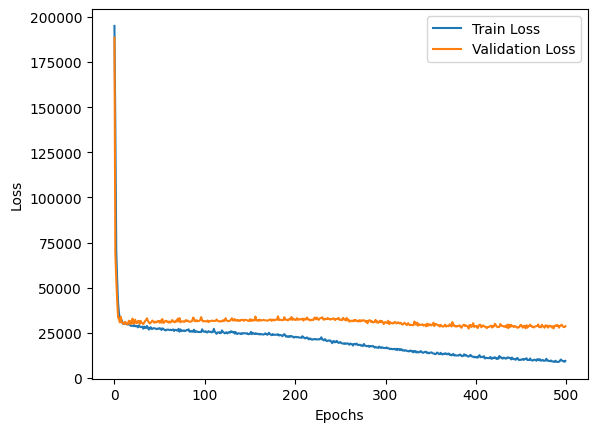

In [414]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
torch.save(model, 'model_Housing_1.pth')

In [415]:
# Report final accuracy
model.eval()
total_val_loss = 0
with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
print("Final Validation loss :", avg_val_loss)
total_parameters = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_parameters}')

Final Validation loss : 28684.143994140624
Total number of parameters in the model: 12929


2.b. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture, but this time also add on-hot encoding. Please plot the training and validation results and report the final accuracy and model complexity. Do you see the meaningful changes against 2.b. (20pt)

In [416]:
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning'
                ,'LotShape','LandContour','Condition1','HouseStyle','SaleCondition',]
df_train_prepro = train_dataset[usefull_cols].copy()

df_train_prepro['GarageArea'] = df_train_prepro['GarageArea'].fillna(df_train_prepro['GarageArea'].mean())
df_train_prepro['TotalBsmtSF'] = df_train_prepro['TotalBsmtSF'].fillna(df_train_prepro['TotalBsmtSF'].mean())

df_train_prepro = pd.get_dummies(df_train_prepro,columns=['Neighborhood','MSZoning','LotShape','LandContour','Condition1','HouseStyle','SaleCondition'])

df_train_prepro = df_train_prepro.replace({True: 1, False: 0})



df_train_prepro = df_train_prepro.apply(pd.to_numeric, errors='coerce').fillna(0)


In [417]:
df_y = train_dataset['SalePrice'].copy()

In [418]:
X_train, X_val, y_train, y_val = train_test_split(df_train_prepro, df_y, test_size=0.2, random_state=42)

In [419]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

train_data = TensorDataset(x_train_tensor, y_train_tensor.view(-1, 1))
val_data = TensorDataset(x_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [420]:
input_size = len(X_val_scaled[0])
model = Housing(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [421]:
num_epochs = 500
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


Epoch 1/500, Train Loss: 196783.8285472973, Val Loss: 196714.2765625
Epoch 11/500, Train Loss: 195912.56672297296, Val Loss: 196675.3171875
Epoch 21/500, Train Loss: 196086.05447635136, Val Loss: 196110.003125
Epoch 31/500, Train Loss: 193426.0920608108, Val Loss: 193719.903125
Epoch 41/500, Train Loss: 187663.078125, Val Loss: 187879.8765625
Epoch 51/500, Train Loss: 177604.27576013515, Val Loss: 177032.471875
Epoch 61/500, Train Loss: 161880.00464527027, Val Loss: 160352.9625
Epoch 71/500, Train Loss: 140130.8524070946, Val Loss: 138455.71171875
Epoch 81/500, Train Loss: 117387.2734375, Val Loss: 115402.72890625
Epoch 91/500, Train Loss: 100991.11655405405, Val Loss: 98612.821875
Epoch 101/500, Train Loss: 92252.32474662163, Val Loss: 90320.98515625
Epoch 111/500, Train Loss: 87044.7347972973, Val Loss: 85308.57890625
Epoch 121/500, Train Loss: 82212.46589949324, Val Loss: 80603.80703125
Epoch 131/500, Train Loss: 76178.84227195945, Val Loss: 75553.000390625
Epoch 141/500, Train Loss

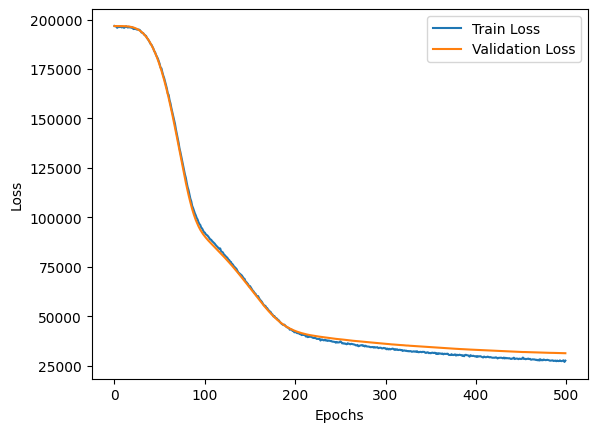

In [426]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
torch.save(model, 'model_Housing_2.pth')

In [427]:
model.eval()
total_val_loss = 0
with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
print("Final Validation loss :", avg_val_loss)
total_parameters = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_parameters}')

Final Validation loss : 31242.385986328125
Total number of parameters in the model: 19841


2.c increase the complexity of the network for problem 2. b and compare your results against 2.b. (10pt)

In [430]:
class Housing_extended(nn.Module):
    def __init__(self, input_size):
        super(Housing_extended, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc6(self.relu(self.fc5(x)))  
        return x

In [431]:
input_size = len(X_val_scaled[0])
model = Housing_extended(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [432]:
num_epochs = 500
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


Epoch 1/500, Train Loss: 196571.59923986485, Val Loss: 196712.9125
Epoch 11/500, Train Loss: 39259.56788429054, Val Loss: 40446.638671875
Epoch 21/500, Train Loss: 28575.667652027027, Val Loss: 32160.990234375
Epoch 31/500, Train Loss: 26131.73044235642, Val Loss: 29923.775512695312
Epoch 41/500, Train Loss: 24507.45288745777, Val Loss: 28863.813427734374
Epoch 51/500, Train Loss: 22834.277264569257, Val Loss: 28714.97626953125
Epoch 61/500, Train Loss: 22216.313766891893, Val Loss: 28233.38603515625
Epoch 71/500, Train Loss: 21495.64595650338, Val Loss: 27454.34931640625
Epoch 81/500, Train Loss: 20932.354122677363, Val Loss: 27312.40593261719
Epoch 91/500, Train Loss: 20417.12642525338, Val Loss: 27307.23447265625
Epoch 101/500, Train Loss: 19499.034522804053, Val Loss: 27114.806201171876
Epoch 111/500, Train Loss: 19379.300438133447, Val Loss: 27292.801220703124
Epoch 121/500, Train Loss: 18875.54903927365, Val Loss: 27322.713427734376
Epoch 131/500, Train Loss: 18615.825802364863, 

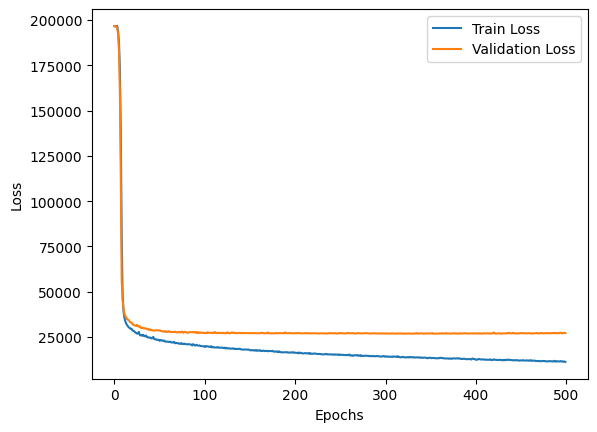

In [433]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
torch.save(model, 'model_Housing_3.pth')

In [434]:
model.eval()
total_val_loss = 0
with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
print("Final Validation loss :", avg_val_loss)
total_parameters = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_parameters}')

Final Validation loss : 27152.571044921875
Total number of parameters in the model: 773121
